In [8]:
!pip install pyspark
!pip install findspark
!pip install pyarrow
!pip install xgboost

In [1]:
import findspark
findspark.init()
import pyspark
from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark.sql.types import *
from pyspark.sql import SparkSession
import pyspark.sql as sparksql
from pyspark.sql.functions import isnan, when, count, col, concat, lit

from pyspark.ml.feature import VectorAssembler,OneHotEncoder,StringIndexer

In [2]:
import pandas as pd

# see the raw data
data = pd.read_csv('train_2v.csv')
data.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,30669,Male,3.0,0,0,No,children,Rural,95.12,18.0,NaN,0
1,30468,Male,58.0,1,0,Yes,Private,Urban,87.96,39.2,never smoked,0
2,16523,Female,8.0,0,0,No,Private,Urban,110.89,17.6,NaN,0
3,56543,Female,70.0,0,0,Yes,Private,Rural,69.04,35.9,formerly smoked,0
4,46136,Male,14.0,0,0,No,Never_worked,Rural,161.28,19.1,NaN,0


In [3]:
# read data into spark
spark = SparkSession.builder.appName('stroke').getOrCreate()
data = spark.read.csv('train_2v.csv', inferSchema=True,header=True)

In [4]:
data.printSchema()

root
 |-- id: integer (nullable = true)
 |-- gender: string (nullable = true)
 |-- age: double (nullable = true)
 |-- hypertension: integer (nullable = true)
 |-- heart_disease: integer (nullable = true)
 |-- ever_married: string (nullable = true)
 |-- work_type: string (nullable = true)
 |-- Residence_type: string (nullable = true)
 |-- avg_glucose_level: double (nullable = true)
 |-- bmi: double (nullable = true)
 |-- smoking_status: string (nullable = true)
 |-- stroke: integer (nullable = true)



In [5]:
data.describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
id,43400,36326.14235023042,21072.13487918279,1,72943
gender,43400,None,None,Female,Other
age,43400,42.21789400921646,22.519648680503554,0.08,82.0
hypertension,43400,0.09357142857142857,0.291234906309397,0,1
heart_disease,43400,0.04751152073732719,0.21273274050209726,0,1
ever_married,43400,None,None,No,Yes
work_type,43400,None,None,Govt_job,children
Residence_type,43400,None,None,Rural,Urban
avg_glucose_level,43400,104.48274999999916,43.1117509512961,55.0,291.05


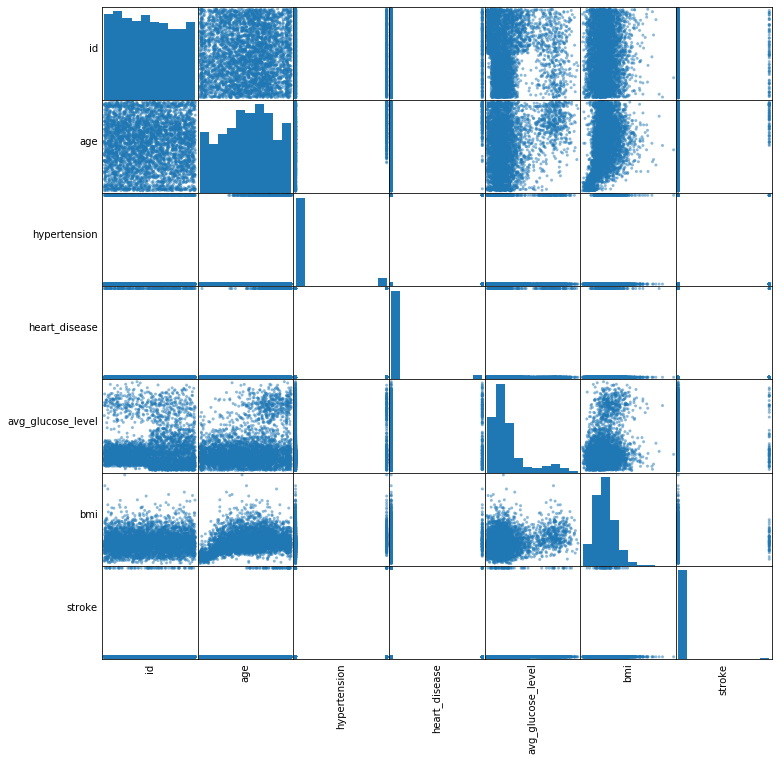

In [6]:
from pandas.plotting import scatter_matrix

numeric_features = [t[0] for t in data.dtypes if t[1] == 'int' or t[1] == 'double']

sampled_data = data.select(numeric_features).sample(False, 0.10).toPandas()

axs = pd.plotting.scatter_matrix(sampled_data, figsize=(12, 12))

# Rotate axis labels and remove axis ticks
n = len(sampled_data.columns)
for i in range(n):
    v = axs[i, 0]
    v.yaxis.label.set_rotation(0)
    v.yaxis.label.set_ha('right')
    v.set_yticks(())
    h = axs[n-1, i]
    h.xaxis.label.set_rotation(90)
    h.set_xticks(())

In [7]:
# imbalanced data
data.groupBy('stroke').count().show()

+------+-----+
|stroke|count|
+------+-----+
|     1|  783|
|     0|42617|
+------+-----+



In [8]:
# create DataFrame as a temporary view
data.createOrReplaceTempView('table')

In [9]:
#see abs number
sql_sen1 = "SELECT work_type, count(work_type) as work_type_count FROM table WHERE stroke = 1 GROUP BY work_type ORDER BY work_type_count DESC"
spark.sql(sql_sen1).show()

+-------------+---------------+
|    work_type|work_type_count|
+-------------+---------------+
|      Private|            441|
|Self-employed|            251|
|     Govt_job|             89|
|     children|              2|
+-------------+---------------+



In [10]:
#see % of stroke in work type
sql_sen2 = "select work_type, round(sum(stroke)/count(work_type)*100,2) as pct from table group by work_type order by pct desc"
spark.sql(sql_sen2).show()

+-------------+----+
|    work_type| pct|
+-------------+----+
|Self-employed|3.69|
|      Private|1.78|
|     Govt_job|1.64|
|     children|0.03|
| Never_worked| 0.0|
+-------------+----+



In [11]:
# % of stroke in gender
sql_sen3 = "SELECT gender, count(gender), round(sum(stroke)/count(gender)*100,2) as pct FROM table GROUP BY gender order by pct desc"
spark.sql(sql_sen3).show()

+------+-------------+----+
|gender|count(gender)| pct|
+------+-------------+----+
|  Male|        17724|1.99|
|Female|        25665|1.68|
| Other|           11| 0.0|
+------+-------------+----+



In [12]:
# check null columns
data.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in data.columns]).show()

+---+------+---+------------+-------------+------------+---------+--------------+-----------------+----+--------------+------+
| id|gender|age|hypertension|heart_disease|ever_married|work_type|Residence_type|avg_glucose_level| bmi|smoking_status|stroke|
+---+------+---+------------+-------------+------------+---------+--------------+-----------------+----+--------------+------+
|  0|     0|  0|           0|            0|           0|        0|             0|                0|1462|         13292|     0|
+---+------+---+------------+-------------+------------+---------+--------------+-----------------+----+--------------+------+



In [13]:
# fill in missing values of smoking status
data = data.na.fill('unknown', subset=['smoking_status'])

In [14]:
# fill the null with median value in BMI columns
bmi_median = data.approxQuantile("bmi", [0.5], 0)
data = data.na.fill(bmi_median[0],['bmi'])

In [15]:
# check null columns
data.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in data.columns]).show()

+---+------+---+------------+-------------+------------+---------+--------------+-----------------+---+--------------+------+
| id|gender|age|hypertension|heart_disease|ever_married|work_type|Residence_type|avg_glucose_level|bmi|smoking_status|stroke|
+---+------+---+------------+-------------+------------+---------+--------------+-----------------+---+--------------+------+
|  0|     0|  0|           0|            0|           0|        0|             0|                0|  0|             0|     0|
+---+------+---+------------+-------------+------------+---------+--------------+-----------------+---+--------------+------+



In [16]:
data.show(5)

+-----+------+----+------------+-------------+------------+------------+--------------+-----------------+----+---------------+------+
|   id|gender| age|hypertension|heart_disease|ever_married|   work_type|Residence_type|avg_glucose_level| bmi| smoking_status|stroke|
+-----+------+----+------------+-------------+------------+------------+--------------+-----------------+----+---------------+------+
|30669|  Male| 3.0|           0|            0|          No|    children|         Rural|            95.12|18.0|        unknown|     0|
|30468|  Male|58.0|           1|            0|         Yes|     Private|         Urban|            87.96|39.2|   never smoked|     0|
|16523|Female| 8.0|           0|            0|          No|     Private|         Urban|           110.89|17.6|        unknown|     0|
|56543|Female|70.0|           0|            0|         Yes|     Private|         Rural|            69.04|35.9|formerly smoked|     0|
|46136|  Male|14.0|           0|            0|          No|Nev

In [17]:
# dealing with categorical variables

gender_indexer=StringIndexer(inputCol='gender',outputCol='genderIndex')
gender_encoder=OneHotEncoder(inputCol='genderIndex',outputCol='genderVec')

ever_married_indexer=StringIndexer(inputCol='ever_married',outputCol='ever_marriedIndex')
ever_married_encoder=OneHotEncoder(inputCol='ever_marriedIndex',outputCol='ever_marriedVec')

work_type_indexer=StringIndexer(inputCol='work_type',outputCol='work_typeIndex')
work_type_encoder=OneHotEncoder(inputCol='work_typeIndex',outputCol='work_typeVec')

residence_type_indexer=StringIndexer(inputCol='Residence_type',outputCol='residence_typeIndex')
residence_type_encoder=OneHotEncoder(inputCol='residence_typeIndex',outputCol='residence_typeVec')

smoking_status_indexer=StringIndexer(inputCol='smoking_status',outputCol='smoking_statusIndex')
smoking_status_encoder=OneHotEncoder(inputCol='smoking_statusIndex',outputCol='smoking_statusVec')

In [18]:
# assembler features
assembler = VectorAssembler(inputCols=['genderVec',
 'age',
 'hypertension',
 'heart_disease',
 'ever_marriedVec',
 'work_typeVec',
 'residence_typeVec',
 'avg_glucose_level',
 'bmi',
 'smoking_statusVec'],outputCol='features')

In [19]:
# split the data into train and test
train_data,test_data = data.randomSplit([0.7,0.3])

In [20]:
train_data.show(5)

+---+------+----+------------+-------------+------------+-------------+--------------+-----------------+----+--------------+------+
| id|gender| age|hypertension|heart_disease|ever_married|    work_type|Residence_type|avg_glucose_level| bmi|smoking_status|stroke|
+---+------+----+------------+-------------+------------+-------------+--------------+-----------------+----+--------------+------+
|  1|Female|80.0|           0|            1|         Yes|Self-employed|         Urban|            67.45|25.6|  never smoked|     0|
|  7|Female|44.0|           0|            0|         Yes|      Private|         Urban|           222.75|19.6|  never smoked|     0|
|  8|Female|79.0|           0|            0|         Yes|      Private|         Urban|            99.23|25.1|       unknown|     0|
| 10|Female|34.0|           0|            0|         Yes|      Private|         Urban|            89.11|28.0|  never smoked|     0|
| 11|Female|54.0|           0|            0|         Yes|Self-employed|     

In [21]:
# try logistic models

In [22]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline

lr = LogisticRegression(maxIter=10,labelCol='stroke',featuresCol='features')

lr_pipeline = Pipeline(stages=[gender_indexer, ever_married_indexer, work_type_indexer, residence_type_indexer,
                           smoking_status_indexer, gender_encoder, ever_married_encoder, work_type_encoder,
                           residence_type_encoder, smoking_status_encoder, assembler, lr])

lr_model = lr_pipeline.fit(train_data)

In [23]:
trainingSummary = lr_model.stages[-1].summary

In [24]:
# Obtain the objective per iteration
objectiveHistory = trainingSummary.objectiveHistory
print("objectiveHistory:")
for objective in objectiveHistory:
    print(objective)

objectiveHistory:
0.08824751638542687
0.08575754657329654
0.08316597211011169
0.07821697415056829
0.07667577402309936
0.07553514037849701
0.07448001422115261
0.07404833115370112
0.07372893762923749
0.07331672969553397
0.07305790015452886


In [25]:
# Obtain the receiver-operating characteristic as a dataframe and areaUnderROC.
trainingSummary.roc.show()
print("areaUnderROC: " + str(trainingSummary.areaUnderROC))

+--------------------+-------------------+
|                 FPR|                TPR|
+--------------------+-------------------+
|                 0.0|                0.0|
|0.008600127658144925|0.08662900188323917|
|0.018073705781570196|0.12429378531073447|
|0.027244935667013807|0.17890772128060264|
|0.036550542547115934|0.22598870056497175|
| 0.04558739543790103|  0.288135593220339|
| 0.05475862532334464| 0.3427495291902072|
| 0.06413142070077603| 0.3860640301318267|
|  0.0736049988242013|  0.423728813559322|
| 0.08321295394228508| 0.4538606403013183|
| 0.09275372056303961|  0.487758945386064|
| 0.10236167568112339| 0.5178907721280602|
| 0.11183525380454866| 0.5555555555555556|
| 0.12167836866328484| 0.5725047080979284|
| 0.13138710652736252| 0.5969868173258004|
| 0.14102865589411093| 0.6252354048964218|
|  0.1508717707528471| 0.6421845574387948|
| 0.16061410286558941|  0.664783427495292|
|  0.1704572177243256| 0.6817325800376648|
| 0.18016595558840326| 0.7062146892655368|
+----------

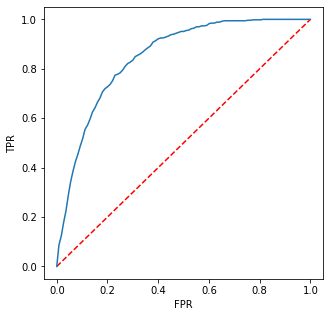

In [26]:
#plot the ROC for training
import matplotlib.pyplot as plt

plt.figure(figsize=(5,5))
plt.plot([0, 1], [0, 1], 'r--')
plt.plot(trainingSummary.roc.select('FPR').collect(),
         trainingSummary.roc.select('TPR').collect())
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()

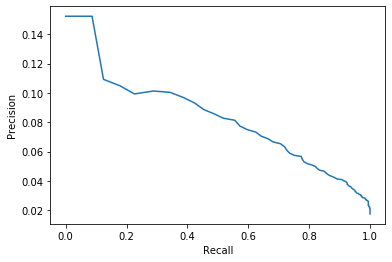

In [27]:
pr = trainingSummary.pr.toPandas()
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

In [28]:
# predit the test data
lr_predictions = lr_model.transform(test_data)

from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Select (prediction, true label) and compute test error
acc_evaluator = MulticlassClassificationEvaluator(labelCol="stroke", predictionCol="prediction", metricName="accuracy")
lr_acc = acc_evaluator.evaluate(lr_predictions)
print('an accuracy of: {0:2.2f}%'.format(lr_acc*100))

an accuracy of: 98.08%


In [29]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

acc_evaluator = BinaryClassificationEvaluator(labelCol='stroke')
print('Test AUC', acc_evaluator.evaluate(lr_predictions))

Test AUC 0.8517065036129852


In [30]:
from pyspark.mllib.evaluation import MulticlassMetrics, BinaryClassificationMetrics
from sklearn.metrics import classification_report, confusion_matrix, recall_score


predict_lable = lr_predictions.select("prediction").toPandas()
test_lable = test_data.select("stroke").toPandas()

print(classification_report(test_lable, predict_lable))
print(confusion_matrix(test_lable, predict_lable))
print(recall_score(test_lable, predict_lable))


              precision    recall  f1-score   support

           0       0.98      1.00      0.99     12850
           1       0.00      0.00      0.00       252

    accuracy                           0.98     13102
   macro avg       0.49      0.50      0.50     13102
weighted avg       0.96      0.98      0.97     13102

[[12850     0]
 [  252     0]]
0.0


C:\Users\jingj\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [31]:
# hyperparameter tuning
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
import numpy as np

lr = LogisticRegression(maxIter=10,labelCol='stroke',featuresCol='features')

lr_paramGrid = ParamGridBuilder() \
    .addGrid(lr.elasticNetParam, [0, 0.2, 0.4, 0.6, 0.8, 1]) \
    .addGrid(lr.regParam, [0.1, 0.01, 0.001, 0.0001]) \
    .build()

lr_pipeline = Pipeline(stages=[gender_indexer, ever_married_indexer, work_type_indexer, residence_type_indexer,
                           smoking_status_indexer, gender_encoder, ever_married_encoder, work_type_encoder,
                           residence_type_encoder, smoking_status_encoder, assembler, lr])

crossval = CrossValidator(estimator=lr_pipeline,
                          estimatorParamMaps=lr_paramGrid,
                          evaluator=BinaryClassificationEvaluator(labelCol='stroke'),
                          numFolds=10)  

# Run cross-validation, and choose the best set of parameters.
lr_cvModel = crossval.fit(train_data)

In [32]:
# show the best parameters
print('Alpha',lr_cvModel.bestModel.stages[-1]._java_obj.getRegParam())
print('ElaticNet', lr_cvModel.bestModel.stages[-1]._java_obj.getElasticNetParam())

Alpha 0.0001
ElaticNet 0.0


In [33]:
print("Coefficients: " + str(lr_model.stages[-1].coefficients))
print("Intercept: " + str(lr_model.stages[-1].intercept))

print("Coefficients after tuning: " + str(lr_cvModel.bestModel.stages[-1].coefficients))
print("Intercept after tuning: " + str(lr_cvModel.bestModel.stages[-1].intercept))

Coefficients: [-1.302946510282215,-1.2118634748917951,0.06679844919423965,0.18153391210932307,0.6207889693005813,-0.5793613212963651,-0.6612109073040655,-0.771927337051329,-2.0871641817183115,-0.666474476624257,-0.02028256352912336,0.0036399166774093994,-0.030714543920547694,-0.37306780379793036,-0.4206629338511984,-0.33061584769661245]
Intercept: -4.636220408960641
Coefficients after tuning: [-1.2419865940213453,-1.1514998614442888,0.06488340060539491,0.1924129391867961,0.6349634028762842,-0.5480298434645605,-0.6350541341694662,-0.7283131572305247,-1.9728444587051954,-0.6432741708131551,-0.02313006934847778,0.0036579035212202177,-0.0314475377122731,-0.35808452340607777,-0.4080180886004166,-0.30856217043285217]
Intercept after tuning: -4.624065826948883


In [61]:
len(lr_cvModel.bestModel.stages[-1].coefficients)

16

In [34]:
# Make predictions on test documents. cvModel uses the best model found (lrModel).
lr_prediction_cv = lr_cvModel.bestModel.transform(test_data)

acc_evaluator = BinaryClassificationEvaluator(labelCol='stroke',rawPredictionCol="rawPrediction")
print('Test AUC', acc_evaluator.evaluate(lr_prediction_cv))

Test AUC 0.8519949354578431


In [35]:
acc_evaluator.getMetricName()

'areaUnderROC'

In [36]:
lr_prediction_cv.select("features","probability","prediction").show(5)

+--------------------+--------------------+----------+
|            features|         probability|prediction|
+--------------------+--------------------+----------+
|(16,[0,2,5,6,11,1...|[0.99401281631623...|       0.0|
|(16,[0,2,6,10,11,...|[0.99779287179593...|       0.0|
|(16,[1,2,5,6,11,1...|[0.99405596158287...|       0.0|
|(16,[1,2,5,9,10,1...|[0.99442721496395...|       0.0|
|(16,[0,2,4,5,7,11...|[0.93023671021457...|       0.0|
+--------------------+--------------------+----------+
only showing top 5 rows



In [37]:
test_data.select("stroke").show(5)

+------+
|stroke|
+------+
|     0|
|     0|
|     0|
|     0|
|     0|
+------+
only showing top 5 rows



In [38]:
predict_lable = lr_prediction_cv.select("prediction").toPandas()
test_lable = test_data.select("stroke").toPandas()

print(classification_report(test_lable, predict_lable))
print(confusion_matrix(test_lable, predict_lable))
print(recall_score(test_lable, predict_lable))


              precision    recall  f1-score   support

           0       0.98      1.00      0.99     12850
           1       0.00      0.00      0.00       252

    accuracy                           0.98     13102
   macro avg       0.49      0.50      0.50     13102
weighted avg       0.96      0.98      0.97     13102

[[12850     0]
 [  252     0]]
0.0


In [39]:
# the recall score is 0, which means a very imbalanced data
# now, we have to deal with the imbalance

In [40]:
#down sampling



down_sample = data.sampleBy('stroke', fractions={0: 783/42617, 1: 1.0}).cache()

down_sample.groupby('stroke').count().toPandas()

,stroke,count
0,1,783
1,0,768


In [64]:
train_data,test_data = down_sample.randomSplit([0.7,0.3])

In [65]:
# hyperparameter tuning
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
import numpy as np

lr = LogisticRegression(maxIter=10,labelCol='stroke',featuresCol='features')

lr_paramGrid = ParamGridBuilder() \
    .addGrid(lr.elasticNetParam, [0, 0.2, 0.4, 0.6, 0.8, 1]) \
    .addGrid(lr.regParam, [0.1, 0.01, 0.001, 0.0001]) \
    .build()

lr_pipeline = Pipeline(stages=[gender_indexer, ever_married_indexer, work_type_indexer, residence_type_indexer,
                           smoking_status_indexer, gender_encoder, ever_married_encoder, work_type_encoder,
                           residence_type_encoder, smoking_status_encoder, assembler, lr])

crossval = CrossValidator(estimator=lr_pipeline,
                          estimatorParamMaps=lr_paramGrid,
                          evaluator=BinaryClassificationEvaluator(labelCol='stroke'),
                          numFolds=10)  

# Run cross-validation, and choose the best set of parameters.
lr_cvModel = crossval.fit(train_data)

In [ ]:
# show the best parameters
print('Alpha',lr_cvModel.bestModel.stages[-1]._java_obj.getRegParam())
print('ElaticNet', lr_cvModel.bestModel.stages[-1]._java_obj.getElasticNetParam())

In [ ]:
# Make predictions on test documents. cvModel uses the best model found (lrModel).
lr_prediction_cv = lr_cvModel.bestModel.transform(test_data)

acc_evaluator = BinaryClassificationEvaluator(labelCol='stroke',rawPredictionCol="rawPrediction")
print('Test AUC', acc_evaluator.evaluate(lr_prediction_cv))

In [ ]:
predict_lable = lr_prediction_cv.select("prediction").toPandas()
test_lable = test_data.select("stroke").toPandas()

print(classification_report(test_lable, predict_lable))
print(confusion_matrix(test_lable, predict_lable))
print(recall_score(test_lable, predict_lable))


In [53]:
#### propensity score matching

In [59]:
down_sample.show()

+-----+------+----+------------+-------------+------------+-------------+--------------+-----------------+----+---------------+------+
|   id|gender| age|hypertension|heart_disease|ever_married|    work_type|Residence_type|avg_glucose_level| bmi| smoking_status|stroke|
+-----+------+----+------------+-------------+------------+-------------+--------------+-----------------+----+---------------+------+
|20980|  Male|67.0|           0|            0|         Yes|      Private|         Urban|            190.7|36.0|formerly smoked|     0|
| 9046|  Male|67.0|           0|            1|         Yes|      Private|         Urban|           228.69|36.6|formerly smoked|     1|
|39038|  Male|11.0|           0|            0|          No|     children|         Rural|            79.03|16.5|        unknown|     0|
|51676|Female|61.0|           0|            0|         Yes|Self-employed|         Rural|           202.21|27.7|   never smoked|     1|
|21130|  Male|33.0|           0|            0|         

In [107]:
prop = down_sample.toPandas()

In [108]:
dum1 = pd.get_dummies(prop['gender'])

In [109]:
dum2 = pd.get_dummies(prop['ever_married'],prefix='married')

In [110]:
dum3 = pd.get_dummies(prop['work_type'])
dum4 = pd.get_dummies(prop['Residence_type'])
dum5 = pd.get_dummies(prop['smoking_status'])

In [111]:
prop_test = prop.loc[:,~prop.columns.isin(['gender','ever_married','work_type','Residence_type','smoking_status'])]
prop_fin = pd.concat([prop_test, dum1, dum2, dum3, dum4, dum5], axis=1)

In [112]:
prop_fin

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke,Female,Male,married_No,...,Never_worked,Private,Self-employed,children,Rural,Urban,formerly smoked,never smoked,smokes,unknown
0,20980,67.0,0,0,190.70,36.0,0,0,1,0,...,0,1,0,0,0,1,1,0,0,0
1,9046,67.0,0,1,228.69,36.6,1,0,1,0,...,0,1,0,0,0,1,1,0,0,0
2,39038,11.0,0,0,79.03,16.5,0,0,1,1,...,0,0,0,1,1,0,0,0,0,1
3,51676,61.0,0,0,202.21,27.7,1,1,0,0,...,0,0,1,0,1,0,0,1,0,0
4,21130,33.0,0,0,229.92,25.9,0,0,1,0,...,0,0,1,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1552,41543,49.0,0,0,93.96,25.1,0,1,0,0,...,0,1,0,0,1,0,0,1,0,0
1553,35057,80.0,0,0,75.91,26.7,1,1,0,0,...,0,0,1,0,0,1,0,1,0,0
1554,64109,62.0,1,1,77.97,31.5,1,0,1,0,...,0,1,0,0,1,0,1,0,0,0
1555,10463,76.0,0,0,100.55,27.7,1,1,0,1,...,0,1,0,0,1,0,0,1,0,0


In [113]:
stroke = prop_fin['stroke']
treatment = prop_fin['married_Yes']
prop_fin = prop_fin.drop(['stroke', 'married_Yes','married_No'], axis=1)

In [114]:
prop_fin

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,Female,Male,Govt_job,Never_worked,Private,Self-employed,children,Rural,Urban,formerly smoked,never smoked,smokes,unknown
0,20980,67.0,0,0,190.70,36.0,0,1,0,0,1,0,0,0,1,1,0,0,0
1,9046,67.0,0,1,228.69,36.6,0,1,0,0,1,0,0,0,1,1,0,0,0
2,39038,11.0,0,0,79.03,16.5,0,1,0,0,0,0,1,1,0,0,0,0,1
3,51676,61.0,0,0,202.21,27.7,1,0,0,0,0,1,0,1,0,0,1,0,0
4,21130,33.0,0,0,229.92,25.9,0,1,0,0,0,1,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1552,41543,49.0,0,0,93.96,25.1,1,0,0,0,1,0,0,1,0,0,1,0,0
1553,35057,80.0,0,0,75.91,26.7,1,0,0,0,0,1,0,0,1,0,1,0,0
1554,64109,62.0,1,1,77.97,31.5,0,1,0,0,1,0,0,1,0,1,0,0,0
1555,10463,76.0,0,0,100.55,27.7,1,0,0,0,1,0,0,1,0,0,1,0,0


In [115]:
treatment

0       1
1       1
2       0
3       1
4       1
       ..
1552    1
1553    1
1554    1
1555    0
1556    0
Name: married_Yes, Length: 1557, dtype: uint8

In [116]:
from sklearn.linear_model import LogisticRegression

logistic = LogisticRegression()
logistic.fit(prop_fin, treatment)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [117]:
pscore = logistic.predict_proba(prop_fin)[:, 1]
pscore

array([0.90692221, 0.90377934, 0.38009166, ..., 0.88817201, 0.97172363,
       0.82351863])

In [119]:
from sklearn.metrics import roc_auc_score

roc_auc_score(treatment, pscore)

0.8176068173748372

In [120]:
mask = treatment == 1
pos_pscore = pscore[mask]
neg_pscore = pscore[~mask]
print('treatment count:', pos_pscore.shape)
print('control count:', neg_pscore.shape)

treatment count: (1207,)
control count: (350,)


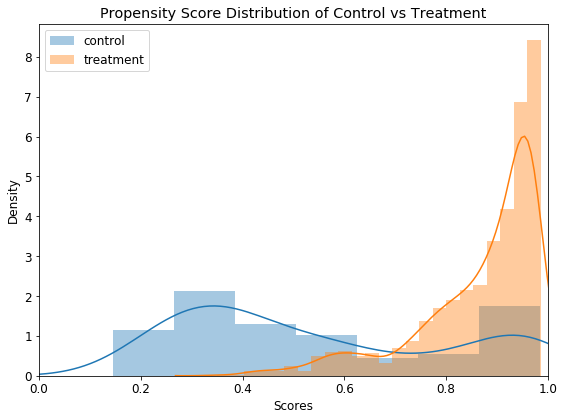

In [122]:
import seaborn as sns

plt.rcParams['figure.figsize'] = 8, 6
plt.rcParams['font.size'] = 12

sns.distplot(neg_pscore, label='control')
sns.distplot(pos_pscore, label='treatment')
plt.xlim(0, 1)
plt.title('Propensity Score Distribution of Control vs Treatment')
plt.ylabel('Density')
plt.xlabel('Scores')
plt.legend()
plt.tight_layout()
plt.show()

In [123]:
def get_similar(pos_pscore: np.ndarray, neg_pscore: np.ndarray, topn: int=5, n_jobs: int=1):
    from sklearn.neighbors import NearestNeighbors

    knn = NearestNeighbors(n_neighbors=topn + 1, metric='euclidean', n_jobs=n_jobs)
    knn.fit(neg_pscore.reshape(-1, 1))

    distances, indices = knn.kneighbors(pos_pscore.reshape(-1, 1))
    sim_distances = distances[:, 1:]
    sim_indices = indices[:, 1:]
    return sim_distances, sim_indices


sim_distances, sim_indices = get_similar(pos_pscore, neg_pscore, topn=1)
sim_indices

array([[311],
       [311],
       [  6],
       ...,
       [ 42],
       [149],
       [209]], dtype=int64)

In [124]:
_, counts = np.unique(sim_indices[:, 0], return_counts=True)
np.bincount(counts)

array([ 0, 28, 22, 11, 10, 16, 10,  5,  5,  1,  6,  9,  3,  3,  3,  1,  2,
        4,  5,  0,  1,  0,  1,  2,  2,  0,  0,  1,  0,  0,  2,  2,  0,  0,
        1,  0,  0,  0,  1], dtype=int64)

In [130]:
df_pos = prop[mask]
df_neg = prop[~mask].iloc[sim_indices[:, 0]]
df_matched = pd.concat([df_pos, df_neg], axis=0)
df_matched.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,20980,Male,67.0,0,0,Yes,Private,Urban,190.70,36.0,formerly smoked,0
1,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
3,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,27.7,never smoked,1
4,21130,Male,33.0,0,0,Yes,Self-employed,Urban,229.92,25.9,smokes,0
6,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1


In [131]:
num_matched_pairs = df_neg.shape[0]
print('number of matched pairs: ', num_matched_pairs)

import scipy.stats as stats

# pair t-test
stats.ttest_rel(df_pos['stroke'].values, df_neg['stroke'].values)

number of matched pairs:  1207


Ttest_relResult(statistic=-0.4051992467513697, pvalue=0.6854029240239381)

In [ ]:
# since the p-vlaue >0.05, we can say whether married or not has noting to do with stroke by using propensity score matching